In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy
import random

In [24]:
class BasicSocialDynamics():
    def __init__(self, size = 50, alpha = 0.03, beta = 0.3, gamma = 4, prob_new_edge = 0.5):
        """
        Size is the number of nodes in the network
        alpha is the rate at which a node adjust its opinion to get closer
            to its neighbor. 
            
        beta is the rate at which the weight of an edge changes in response
            to the opinion change. 
            
        gamma is the pickiness of a node. If the node difference is greater
            than 1/gamma, the edge weight will decrease. 
        """
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.prob_new_edge = prob_new_edge
        
        #initialize the network configuration:
        self.config = nx.watts_strogatz_graph(size, 5, 0.5)
        
        #the initial weight of all edges is 0.5
        for edge in self.config.edges:
            self.config.edges[edge]['weight'] = 0.5
        #randomize the opinions in nodes between 0 and 1:
        for node in self.config.nodes:
            self.config.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.config)
        self.step = 0
        self.converge = False
        self.split = False
        
    def display(self, ax='None', return_ax=False):
        """
        Draw the network
        """
        if ax=='None':
            fig, ax = plt.subplots(figsize=(8,6))
        else:
            return_ax = True
            
        self.layout = nx.spring_layout(self.config, pos = self.layout, iterations = 5)
        nx.draw(
            self.config, pos = self.layout, with_labels = True,
            node_color = [self.config.nodes[i]['opinion'] for i in self.config.nodes],
            edge_color = [self.config.edges[edge]['weight'] for edge in self.config.edges],
            edge_cmap = plt.cm.binary, edge_vmin = 0, edge_vmax = 1,
            alpha = 0.7, vmin = 0, vmax = 1, ax=ax)
        ax.set_title("Step: " + str(self.step))
        
        if return_ax:
            return ax
        else:
            fig.show()
        
    def degrees_display(self, ax='None', return_ax=False):
        """
        Show the degree histogram for the network
        """
        if ax=='None':
            fig, ax = plt.subplots(figsize=(8,6))
        else:
            return_ax = True
        degrees = [self.config.degree(node) for node in self.config.nodes]
        ax.hist(degrees, density=True)
        ax.set_xlabel("Degree")
        #ax.set_title("Step: " + str(self.step))
        
        if return_ax:
            return ax
        else:
            fig.show()
    
    def check_converge(self):
        """
        Check if the network is converged or not.
        The result will show in self.converge attribute.
        A network is converged if the largest opinion difference in the network is less than 0.1
        """
        opinions = [self.config.nodes[node]['opinion'] for node in self.config.nodes]
        if max(opinions) - min(opinions) < 0.1:
            self.converge = True
        else:
            self.converge = False
            
    def check_split(self):
        """
        Check if the network is splitted into two clusters or not.
        The result will show in self.split attribute. 
        A network is split if the number of extreme edges - the edges that connect two extreme ideas,
        is less than 1% of the total number of edges.
        """
        
        extreme_edges = [] #The edges that connect two extremes ideas (opinion difference >= 0.5)
        for edge in self.config.edges:
            if abs(self.config.nodes[edge[0]]['opinion'] - self.config.nodes[edge[1]]['opinion']) >= 0.5:
                extreme_edges.append(edge)
        if len(extreme_edges)/len(self.config.edges) < 0.01:
            self.split = True
        else:
            self.split = False
                
    def update(self):
        if random.uniform(0, 1) < self.prob_new_edge:
            #Create a new edge with weight 0.5 between two unconnected nodes:
            nodes = list(self.config.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.config.edges:
                    break
            self.config.add_edge(new_edge[0], new_edge[1], weight = 0.5)
            
        else:
            #select a random edge and update node opinions and edge weight:
            edge = random.choice(list(self.config.edges))
            weight = self.config.edges[edge]['weight']
            opinions = [self.config.nodes[node]['opinion'] for node in edge]
            
            for i in [0, 1]:
                #update the opinion of each node in the random edge
                self.config.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha*weight*(opinions[1-i] - opinions[i]))
            #update the weight between two nodes after the opinion change
            self.config.edges[edge]['weight'] = (
                weight + self.beta*weight*(1-weight)*(1-self.gamma*abs(opinions[0] - opinions[1])))
                
            #remove weak connections:
            if self.config.edges[edge]['weight'] < 0.05:
                self.config.remove_edge(*edge)
        self.step += 1

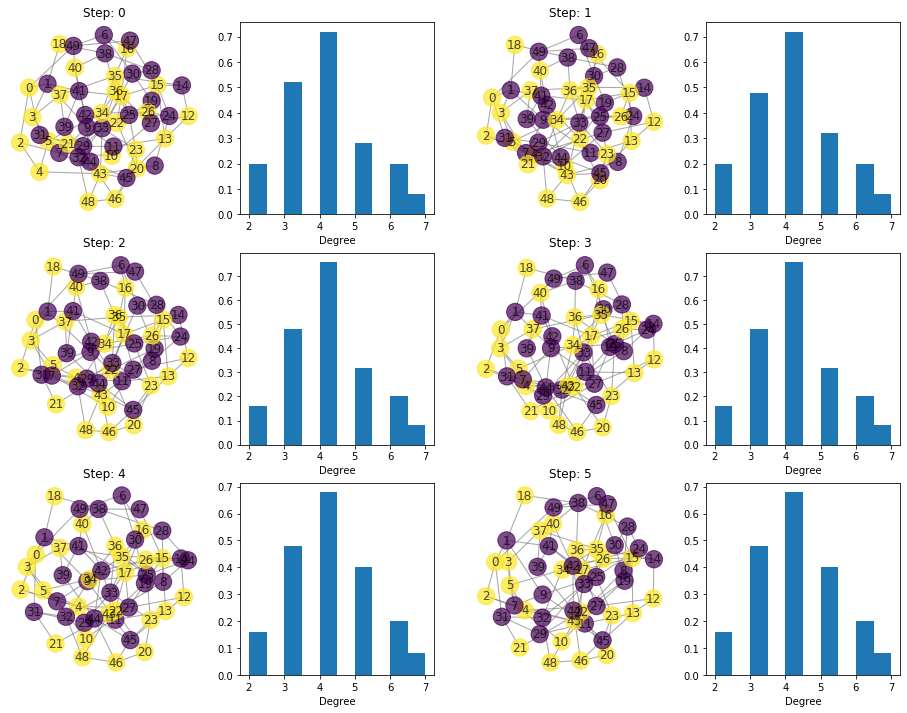

In [23]:
sim =  BasicSocialDynamics()
fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(16,12))
axes = axes.flatten()
for i in range(6):
    sim.display(ax=axes[2*i], return_ax=True)
    sim.degrees_display(ax=axes[2*i+1], return_ax=False)
    sim.update()